In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib

from supernova import LightCurve2
import define_filters
import connect_to_sndavis

Using matplotlib backend: Qt5Agg


# Investigate availability of 17eaw data

In [2]:
sn17eaw = LightCurve2('2017eaw')

In [3]:
sn17eaw.get_photometry()

In [4]:
sn17eaw.apparent_mag.keys()

dict_keys(['g', 'us', 'r', 'uw2', 'uw1', 'i', 'vs', 'V', 'B', 'bs', 'um2'])

In [6]:
sn17eaw.jd['us'] - sn17eaw.jdexpl

array([  1.41915,   1.41984,   2.1926 ,   3.35076,   3.35145,   3.61246,
         3.61315,   3.68202,   5.34207,   5.34276,  11.04797])

# Look at wavelength ranges of each filter (cenwave+fwhm/2)

In [9]:
filters = define_filters.define_filters()

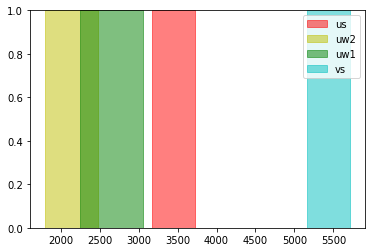

In [21]:
colors = ['r', 'y', 'g', 'c']
for c, ifilter in zip(colors,['us', 'uw2', 'uw1', 'vs', 'um2']):
    plt.axvspan(filters[ifilter][2]-filters[ifilter][1]/2, filters[ifilter][2]+filters[ifilter][1]/2, label=ifilter, color=c, alpha=0.5)
plt.legend(loc='best')

# Compare colors

In [25]:
sn15oz = LightCurve2('asassn-15oz')
sn15oz.get_photometry()

In [28]:
print(sn15oz.jd.keys())
print(sn15oz.jd['us'] - sn15oz.jdexpl)

dict_keys(['g', 'us', 'i', 'uw2', 'I', 'vs', 'bs', 'U', 'um2', 'r', 'uw1', 'V', 'R', 'B'])
[   7.92862   13.33555   19.38309   19.58019   22.89712   28.14938
   31.71191   36.03614   41.29183   67.61236   71.00992   83.04274
   14.88273   15.05753  755.15697]


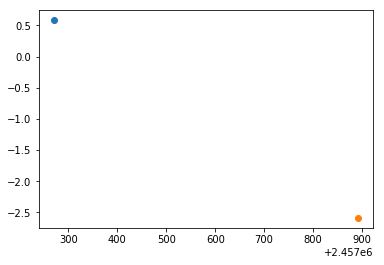

In [29]:
plt.plot(sn15oz.jd['uw2'][0], sn15oz.apparent_mag['uw2'][0]-sn15oz.apparent_mag['vs'][0], 'o', label='15oz - >7.92')
plt.plot(sn17eaw.jd['uw2'][-1], sn17eaw.apparent_mag['uw2'][-1] - sn15oz.apparent_mag['vs'][-1], 'o', label='17eaw - 11.04d')

# Look at lots of supernovae

In [33]:
db, cursor = connect_to_sndavis.get_cursor()

## Select all SN with uw2 and vs data

In [108]:
sql_query = '''SELECT DISTINCT name, slope
FROM photometry
JOIN supernovanames ON photometry.targetid=supernovanames.targetid
JOIN snslope ON photometry.targetid=snslope.targetid
WHERE photometry.filter='uw2' AND slopetype='s50';'''
cursor.execute(sql_query)
results = cursor.fetchall()
snname_uw2=[]
snslope_uw2=[]
for i in results:
    snname_uw2.append(i['name'])
    snslope_uw2.append(i['slope'])
snslope_uw2 = np.array(snslope_uw2)

In [109]:
sql_query = '''SELECT DISTINCT name
FROM photometry
JOIN supernovanames ON photometry.targetid=supernovanames.targetid
WHERE filter='vs';'''
cursor.execute(sql_query)
results = cursor.fetchall()
snname_vs=[]
for i in results:
    snname_vs.append(i['name'])

In [110]:
snlist = list(set(snname_uw2) & set(snname_vs))
max_slope = np.max(snslope_uw2)*100+0.001

In [115]:
cols = [(0,0,0)]
for x in np.linspace(0,1, 254):
    rcol = (0.472-0.567*x+4.05*x**2)/(1.+8.72*x-19.17*x**2+14.1*x**3)
    gcol = 0.108932-1.22635*x+27.284*x**2-98.577*x**3+163.3*x**4-131.395*x**5+40.634*x**6
    bcol = 1./(1.97+3.54*x-68.5*x**2+243*x**3-297*x**4+125*x**5)
    cols.append((rcol, gcol, bcol))

#cols.append((1,1,1))
cm_rainbow = mpl.colors.LinearSegmentedColormap.from_list("PaulT_rainbow", cols)


In [185]:
fig = plt.figure()
gs1 = mpl.gridspec.GridSpec(1, 9)
ax1 = plt.subplot(gs1[0,0:8])
ax2 = plt.subplot(gs1[0,8])
for sn in snlist:
    if sn == 'ASASSN-15oz' or sn == '2009kr':
        continue
    slope_color=cm_rainbow(float(snslope_uw2[np.array(snname_uw2)==sn]*100/max_slope))
    snobj = LightCurve2(sn)
    snobj.get_photometry()
    if sn.startswith('ASA'):
        label = 'ASAS-SN {}'.format(sn.split('-')[1])
    else:
        label=sn
    vs_interp = np.interp(snobj.jd['uw2'], snobj.jd['vs'], snobj.apparent_mag['vs'])
    jderr = np.ones(len(snobj.jd['uw2']))*snobj.jdexpl_err
    #ax1.errorbar(snobj.jd['uw2']-snobj.jdexpl, snobj.apparent_mag['uw2']-vs_interp, xerr=jderr, fmt='o', c=slope_color, label=label, ecolor='k', elinewidth=0.5)
    ax1.errorbar(snobj.jd['uw2']-snobj.jdexpl, snobj.apparent_mag['uw2']-vs_interp, xerr=jderr, fmt='o', c=slope_color, label=label, elinewidth=0.5)
vs_interp = np.interp(sn15oz.jd['uw2'], sn15oz.jd['vs'], sn15oz.apparent_mag['vs'])
slope_color=cm_rainbow(float(snslope_uw2[np.array(snname_uw2)=='ASASSN-15oz']*100/max_slope))
jderr_15oz = np.ones(len(sn15oz.jd['uw2']))*sn15oz.jdexpl_err
#ax1.errorbar(sn15oz.jd['uw2']-sn15oz.jdexpl, sn15oz.apparent_mag['uw2']-vs_interp, xerr=jderr_15oz, fmt='*', c=slope_color, markersize=15, label='ASAS-SN 15oz', ecolor='k', elinewidth=0.5)
ax1.errorbar(sn15oz.jd['uw2']-sn15oz.jdexpl, sn15oz.apparent_mag['uw2']-vs_interp, xerr=jderr_15oz, fmt='*', c=slope_color, markersize=15, label='ASAS-SN 15oz', elinewidth=0.5)
ax1.plot(sn15oz.jd['uw2']-sn15oz.jdexpl, sn15oz.apparent_mag['uw2']-vs_interp,  '*', c=slope_color, markersize=15, label='ASAS-SN 15oz', mec='k')
ax1.set_xlim(0,30)
ax1.set_xlabel('Phase (days)')
ax1.set_ylabel('UVW2-V (magnitude)')
ax1.legend(loc='best', fontsize='x-small')
ax1.set_ylim(-2.5, 5)
norm = mpl.colors.Normalize(vmin=0, vmax=1.0/100*max_slope*50)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cm_rainbow,
                                norm=norm)
ax2.set_ylabel('Slope (mag/50 day)')
plt.savefig('../figures/uv_slope_comp.pdf')

# Investigate if we expect from CSM model?